<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/2_Clasificadores_ConceptosBasicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificadores - conceptos básicos**


*Códigos referencia del libro Hands-On Machine Learning with Scikit-Learn and Tensor Flow 2017 (Cap 3) -- Aurélien Géron

# Configuraciones básicas

Preparar módulos de Python:

In [1]:
import numpy as np #importar numpy
import os

# asesgurar mismos resultados para presentación se deja semilla fija
np.random.seed(42)

# gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#crear carpeta con resultados
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# MNIST : "Hello world" de clasificación 

- La base de datos [Mnist](http://yann.lecun.com/exdb/mnist/) contiene imágenes los digitos del 0 al 9 escritos a mano alzada por muchas personas.

- Primero se ordenan los datos para asegurar repetibilidad de los experimentos. Note que se ordenan por separado el conjunto de entrenamiento (primeras 60000 imágenes) y el conjunto de evaluación (las restantes 10000).

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
from sklearn.datasets import fetch_openml #librería con bases de datos de sklearn
mnist = fetch_openml('mnist_784', version=1, cache=True) #descargar datos desde sklearn
mnist.target = mnist.target.astype(np.int8) # las etiquetas estan codificadas como int
sort_by_target(mnist) # se ordenan datos según etiquetas

mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

- La base de datos Mnist consta de 70000 muestras, con imágenes de 28 x 28 = 784 (atributos) en escala de grises.

In [6]:
mnist.data.shape # se cuenta con 7000

(70000, 784)

- Se define la base de datos estructurada muestras x atributos y el vector etiquetas.

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

- Se grafica un ejemplo de la base de datos como imagen

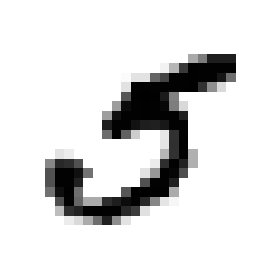

In [10]:
some_digit = X[36000] #alguna muestra
some_digit_image = some_digit.reshape(28, 28) # se reorgniza el vector de 784 en imagen de 28 x 28
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest") #se gráfica imágen con interpolador de vecinos para mejorar visualización
plt.axis("off") #quitar rejilla
plt.tight_layout() #ajustar figura
plt.savefig('results/some_digit_plot.pdf', format='pdf', dpi=300)
plt.show()

In [11]:
def plot_digit(data): #función graficar dígito
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

- Se presentan algunos ejemplos por clase para ilustrar la variabilidad en las formas de los digitos.

In [14]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)#muestras por fila
    images = [instance.reshape(size,size) for instance in instances] #identificar cantidad de imagenes a pixels
    n_rows = (len(instances) - 1) // images_per_row + 1 #redondeo para determinar num de filas
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty))) #crear arreglo completo para las imágenes
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1)) #indexar imágenes y concatenar filas por clase
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

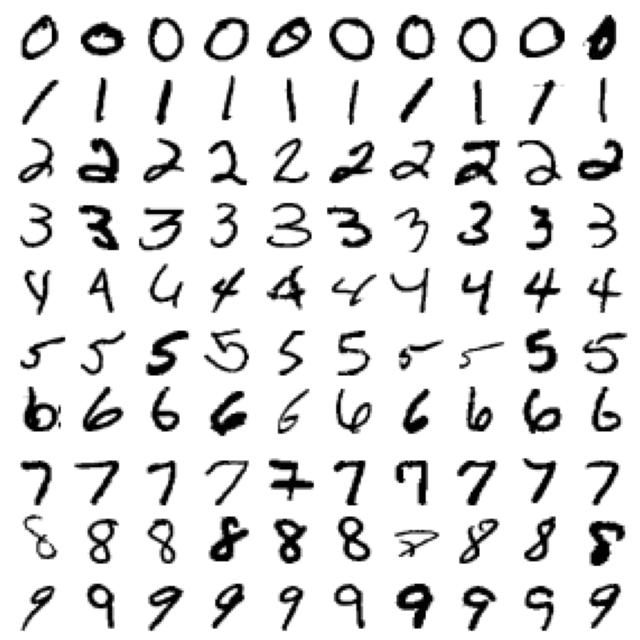

(100, 784)

In [15]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] #concatenar por filas
plot_digits(example_images, images_per_row=10)
plt.tight_layout()
plt.savefig('results/full_digits_plot.pdf', format='pdf', dpi=300)
plt.show()
np.shape(example_images)

# Definir conjuntos de entrenamiento y evaluación.

- Se toman las primeras 60000 imágenes como entrenamiento

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #particionar train y test

- Para asegurar muestras i.i.d se barajan las muestras

In [18]:
shuffle_index = np.random.permutation(60000) #permutación datos
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Ejemplo clasificador binario

- Primero se ilustra el concepto de clasificación a partir del proble 5 vs no 5.

In [19]:
y_train_5 = (y_train == 5) # clasificador 5 vs NO 5
y_test_5 = (y_test == 5) 

- Se probará el [clasificador SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), perceptrón simple

In [20]:
from sklearn.linear_model import SGDClassifier #clasificador lineal por gradiente

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)#definir objeto sgd
sgd_clf.fit(X_train, y_train_5)#ajustar modelo

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [21]:
sgd_clf.predict([some_digit]) #clasificar dígito 5

array([False])

- Es preciso aclarar que el caso 5 vs no 5 presenta un alto desbalance de los datos.

- Aprox. el 90% de las muestras pertenecerán al grupo no 5.

- Revisemos el conteo de las etiquetas:

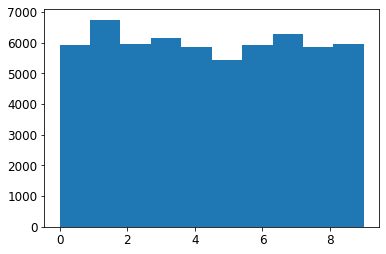

In [24]:
plt.hist(y_train) #histograma etiquetas
plt.show()

- Si realizamos una validación cruzada simple en términos del acierto de clasificación, el sistema *paracerá* clasificar bien, dado que el acierto es un promedio simple para cuando la predicción iguala la etiqueta objetivo:

$$ACC = \frac{1}{N}\sum_{n=1}^N \delta(y_n-\hat{y}_n)$$
donde $\delta(\cdot)$ es la [función delta](https://es.wikipedia.org/wiki/Delta_de_Dirac) y $y_n,\hat{y}_n\in\mathbb {Z}$ representan las etiquetas originales y estimadas, respectivamente.

-Sin embargo, es claro que el modelo se sobreajusta a clasificar no 5.


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") #evaluar clasificador según acierto

array([0.9492, 0.9598, 0.9689])

- Incluso, se aplicamos una vaildación cruzada con estratificación, el desbalance es muy fuerte y el sistema sigue sobreajustándose.

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) #generar partición balanceada

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9492
0.9598
0.9689


# Clasificador tonto nunca 5.

- En este caso, si revisamos solo es ACC, podemos definir un clasificado *tonto* que siempre arroje no 5 como predicción, y el ACC seguirá por encima del 90%.

In [28]:
from sklearn.base import BaseEstimator #clase básica para construir modelos en scikitlearn
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): #métddo de ajuste
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)#método de predicción

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.91135, 0.90795])

# La matriz de confusión

- Si revisamos en detalle las predicciones, nos daremos cuenta que aunque el acierto es alto, en clases con pocos datos las predicciones no son correctas.

- Para ello podemos utilizar la matriz de confusión como alternativa.

- Primero estimaremos las salidas bajo validación cruzada, y calcularemos la matriz de confusión.

- El método cross_val_predict devuelve un vector de salidas igual a la cantidad de muestras de entrada, fijando como salida el valor de predicción de cada muestra cuando dicha muestra estuvo en el conjunto de evaluación.

In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #genera predicción de cada muestra según su aparición en validación

In [33]:
y_train_pred.shape

(60000,)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53598,   981],
       [ 1461,  3960]])

- La matriz de confusión binaria, nos permite revelar la cantidad de verdaderos negativos, falsos positivos, falsos negativos y verdaderos positivos.

$$confusion-matrix=\begin{bmatrix}True Negative & False Positive \\
False Negative & True Positive
\end{bmatrix}$$

- Es calro que la clase 5 no fue muy bien clasificada.

- Una clasificación perfecta deberá arrojar una matriz de confusión tipo diagonal.

In [37]:
y_train_perfect_predictions = y_train_5

In [38]:
print(confusion_matrix(y_train_5, y_train_perfect_predictions))
#[[TN FP][FN TP]]

[[54579     0]
 [    0  5421]]


- A partir de la matríz de confusión se pueden generar algunas otras medidas relacionadas con los conceptos de probabilidad de detección, false alarma y curva ROC (como extensiones a los conceptos básicos en teoría de detección).

In [39]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # TP/(TP+FP)

0.8014571948998178

$$PrecisionScore=\frac{TruePositive}{TruePositive+FalsePositive}$$



In [40]:
recall_score(y_train_5, y_train_pred) # TP/(TP+FN)

0.7304925290536801

$$RecallScore=\frac{TruePositive}{TruePositive+FalseNegative}$$

In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 2/(1/pre + 1/rec) = TP/(TP + (FN+FP)/2)

0.7643312101910827

$$f1score=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=\frac{TruePositive}{TruePositive+\frac{FalseNegative+FalsePositive}{2}}$$

# Score de decisión

- En muchas ocasiones, en problemas de clasificación, la robustez del modelo puede cuantificarse mejor a partir del score (generalmente definido como una probabilidad o una distancia a la forntera de decisión), en lugar de la umbralización del mismo = etiqueta.

In [42]:
y_scores = sgd_clf.decision_function([some_digit]) #estimar score del dígito de prueba
y_scores

array([-117421.59910995])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) #etiqueta como umbralización del score

In [44]:
y_some_digit_pred

array([False])

- Si cambiamos el umbral, indirectamente movemos la frontera de decisión.

In [46]:
threshold = -200000 #cambiar umbral para sesgar clasificador según precisión o exahustividad
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- Podemos utilizar cross_val_predict fijando decision function para guardar el score de cada muestra.

In [47]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

- El score nos permite cuantificar la estabilidad del modelo ante variaciones del umbral (cambios alrededor de la frontera de decisión).

In [48]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #estimar precisión y exahustividad variando los umbrales

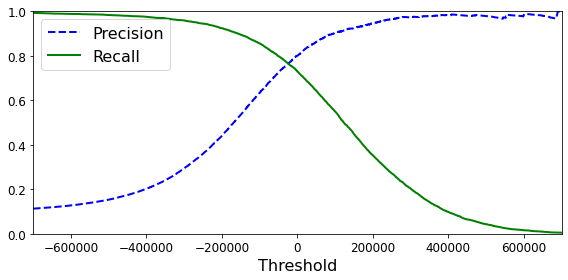

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.tight_layout()
plt.savefig('results/precision_recall_vs_threshold_plot.pdf', format='pdf', dpi=300)
plt.show()

- Según la gráfica anterior, podriamos jugar con el umbral para favorecer el rendimiento en recall o exahustividad según la necesidad.

In [50]:
(y_train_pred == (y_scores > 0)).all() #revisar si todos cumplen condición
#por defecto scikitlearn evalua clasificador con umbral en 0

True

In [51]:
y_train_pred_90 = (y_scores > 70000) # nueva frontera cambiando el umbral de 0 a 70000

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.8823529411764706

In [53]:
recall_score(y_train_5, y_train_pred_90) # por nuevo umbral se ajusta exahustividad

0.6059767570558937

- Para visualizar de forma compacta el recall y precision, se puede generar una curva uniendo dichos valores para cada umbral fijado.

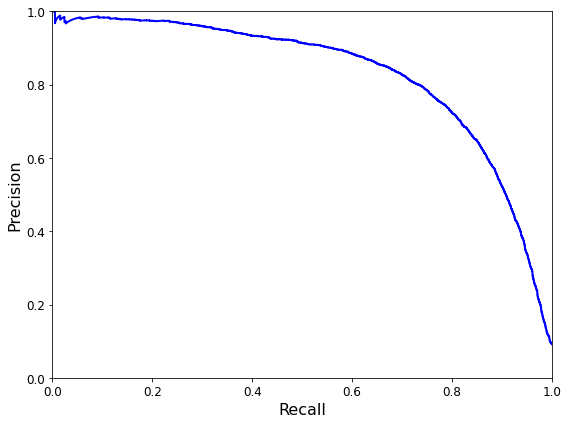

In [55]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.tight_layout()
plt.savefig('results/precision_vs_recall_plot.pdf', format='pdf', dpi=300)
plt.show()

# Curva ROC: reciever operating characteristic
Característica Operativa del Receptor

- Generalmente, en problemas de analítica de datos se utiliza la [curva ROC](https://es.wikipedia.org/wiki/Curva_ROC) bajo el mismo principio de recall vs precision, y se relaciona con los conceptos de sensibilidad y especificidad (muy comunes en el área de salud).

$$FalsePositiveRate = \frac{FalsePositive}{\#samples}=1-specificity$$

$$TruePositiveRate = \frac{TruePositive}{TruePositive+FalseNegative}=sensitivity$$

- Los valores se cálculan variando el umbral de decisión del clasificador para generar una curva, la curva ROC

- **Nota**: recuerde que:

$$confusion-matrix=\begin{bmatrix}True Negative & False Positive \\
False Negative & True Positive
\end{bmatrix}$$

In [56]:
from sklearn.metrics import roc_curve
#matriz confusión = #[[TN FP][FN TP]]
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # Fpr = FP/N -> 1 - especificidad , Tpr = TP/(TP+FN) -> exahustividad (recall, sensibilidad)
#especificidad = TN/(TN+FP)

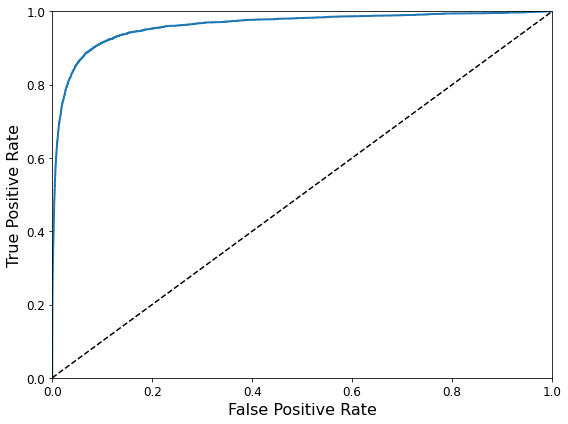

In [57]:
def plot_roc_curve(fpr, tpr, label=None): #función para graficar curva roc
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.tight_layout()
plt.savefig('results/roc_curve_plot.pdf', format='pdf', dpi=300)
plt.show()

- Dado que la curva ROC genera valores valores (medidas de desempeño), se puede calcular el área bajo dicha curva (AUC) para generar un único valor de rendimiento.

- El clasificador ideal presentará $AUC=1$.

In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)#clasificador perfecto AUC = 1; clasificador aleatorio AUC = 0.5

0.9615806367628459

- Comparemos la curva ROC del SGD contra un clasificador más completo.

In [59]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

- **Nota**: Se debe revisar en la documentación el principio del score del clasificador usado: distancia a frontera o probabilidad de membresia de clase.

In [60]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

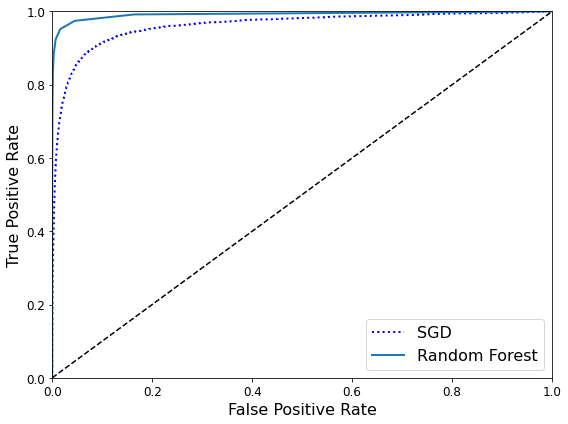

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.savefig('results/roc_curve_comparison_plot.pdf', format='pdf', dpi=300)
plt.show()

**Nota**: Se recomienda usar la curva precisión vs exahustividad cuando la clase positiva es escasa o cuando es más importante en la aplicación evitar los falsos positivos que los falsos negativos, y la curva ROC en caso contrario (es más importante evitar los falsos negativos que los falsos positivos, ej. problemas de salud).

In [63]:
roc_auc_score(y_train_5, y_scores_forest)#mejor AUC que SGD

0.991852822111278

# Clasificación multiclase

In [54]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # si el clasificador es netamente binario aplica estrategia one vs all, 
#a excepción de las svm que aplica one vs one para evitar costo computacional

array([5], dtype=int8)

In [55]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [56]:
np.argmax(some_digit_scores) # máximo score para 5 vs all

5

In [57]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [58]:
sgd_clf.classes_[5]

5

In [59]:
from sklearn.multiclass import OneVsOneClassifier #extensión a one vs one
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [60]:
len(ovo_clf.estimators_) #se generan 45 combinaciones C(C-1)/2

45

In [61]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit]) #algunos clasificadores ya incluyen multiclase desde el score o probabilidad de membresia

array([5], dtype=int8)

In [62]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # un clasificador aleatorio obtendria un 0.1 dado que C = 10

array([0.8618, 0.8675, 0.8389])

In [64]:
from sklearn.preprocessing import StandardScaler #el preproceso puede ayudar a mejorar la clasificación
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9091 , 0.90955, 0.9062 ])

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred,normalize='true')#normaliza sobre suma de filas
conf_mx

array([[9.67077495e-01, 5.06500084e-04, 3.03900051e-03, 1.68833361e-03,
        1.85716698e-03, 8.10400135e-03, 9.11700152e-03, 1.68833361e-03,
        6.41566774e-03, 5.06500084e-04],
       [2.96647879e-04, 9.59952536e-01, 6.37792940e-03, 4.00474637e-03,
        8.89943637e-04, 6.08128152e-03, 8.89943637e-04, 1.33491546e-03,
        1.83921685e-02, 1.77988727e-03],
       [9.90265190e-03, 6.54582075e-03, 8.89560255e-01, 1.72876804e-02,
        1.61127895e-02, 4.02819738e-03, 1.66163142e-02, 9.56696878e-03,
        2.80295401e-02, 2.34978181e-03],
       [9.78633176e-03, 6.85043223e-03, 2.16930354e-02, 8.73756320e-01,
        6.52422117e-04, 3.47414777e-02, 5.70869352e-03, 8.48148752e-03,
        2.20192465e-02, 1.63105529e-02],
       [2.39643958e-03, 4.79287915e-03, 5.64875043e-03, 1.54056830e-03,
        9.18521054e-01, 1.36939404e-03, 9.58575830e-03, 5.64875043e-03,
        1.50633345e-02, 3.54330709e-02],
       [1.25438111e-02, 9.03892271e-03, 5.53403431e-03, 3.63401586e-02,
   

In [66]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


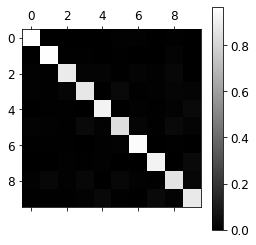

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.tight_layout()
plt.colorbar()
plt.savefig('results/confusion_matrix_plot.pdf', format='pdf', dpi=300)
plt.show()

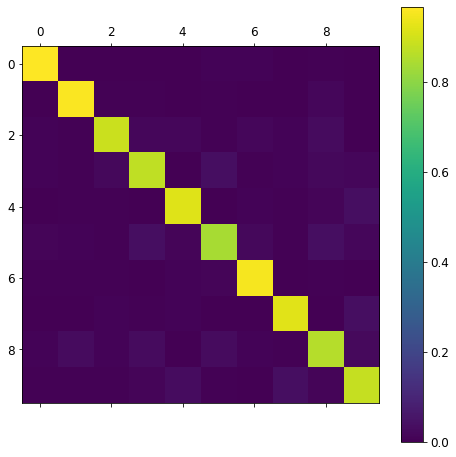

In [68]:
plot_confusion_matrix(conf_mx) # matriz de confusión con barra de colores
plt.savefig('results/confusion_matrix_plot_color.pdf', format='pdf', dpi=300)
plt.show()

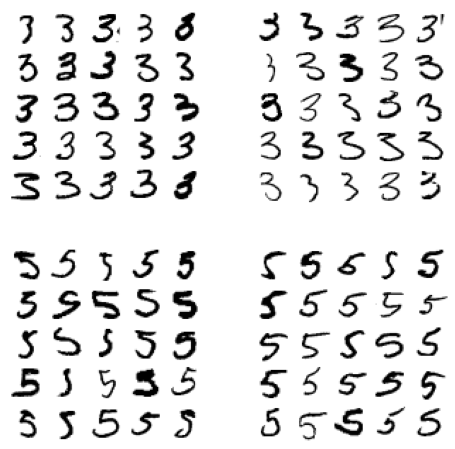

In [69]:
cl_a, cl_b = 3, 5 #analizar errores puntuales
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3 como 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3 como 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5 como 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5 como 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig('results/error_analysis_digits_plot.pdf', format='pdf', dpi=300)
plt.show()

# Clasificación multi-etiqueta (cada etiqueta es binaria)

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # digito mayor o igual a 7
y_train_odd = (y_train % 2 == 1) # digito impar
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**:La siguiente celda puede ser costosa de calcular (puede tardar horas depiendo del hardware)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Clasificación multi-salida -> extensión de multietiqueta a multicalse

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)


# Guardar resultados

In [ ]:
from google.colab import files
from datetime import date, datetime
import shutil
#guardar resultados
namefile = str(datetime.now().strftime("%Y_%m_%d_%H_%M_%d"))+'__results'
shutil.make_archive(namefile, 'zip', 'results')
files.download(namefile+'.zip')